In [152]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm

## Данные

In [153]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [154]:
fashion_train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
fashion_test_dataset  = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

In [155]:
mnist_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
mnist_test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

In [156]:
def show_images(dataset, num_images=7):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        image, _ = dataset[i]
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.show()

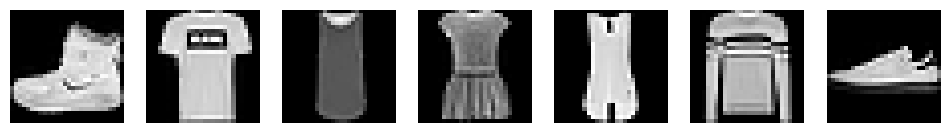

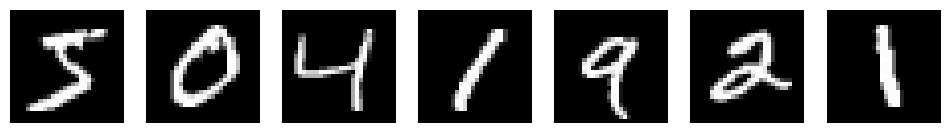

In [157]:
show_images(fashion_train_dataset)
show_images(mnist_train_dataset)

In [158]:
batch_size = 64

In [159]:
fashion_train_loader = DataLoader(fashion_train_dataset, batch_size=batch_size, shuffle=True)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=batch_size, shuffle=False)

In [160]:
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

## Сверточная сеть

In [161]:
class MultiHeadCNN(nn.Module):
    def __init__(self):
        super(MultiHeadCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.head1 = nn.Conv2d(64, 10, kernel_size=1)
        self.head2 = nn.Conv2d(64, 10, kernel_size=1)

    def forward(self, x):
        features = self.conv(x)
        pooled = self.global_pool(features)
        pooled = pooled.view(pooled.size(0), -1)

        logits1 = self.head1(pooled.view(pooled.size(0), 64, 1, 1))
        logits2 = self.head2(pooled.view(pooled.size(0), 64, 1, 1))

        return logits1.view(logits1.size(0), -1), logits2.view(logits2.size(0), -1)

In [163]:
device = torch.device('cpu')
model = MultiHeadCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Обучение на FashionMNIST

In [164]:
num_epochs = 10
train_losses_fashion = []
test_acc_fashion = []

In [165]:
for param in model.head2.parameters():
    param.requires_grad = False

In [166]:
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(fashion_train_loader, desc=f"Epoch {epoch}", leave=True):
        images, labels = images.to(device), labels.to(device)
        logits1, _ = model(images)
        loss = criterion(logits1, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(fashion_train_loader)
    train_losses_fashion.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in fashion_test_loader:
            images, labels = images.to(device), labels.to(device)
            logits1, _ = model(images)
            preds = torch.argmax(logits1, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    test_acc_fashion.append(accuracy)

Epoch 10: 100%|██████████| 938/938 [00:53<00:00, 17.55it/s]


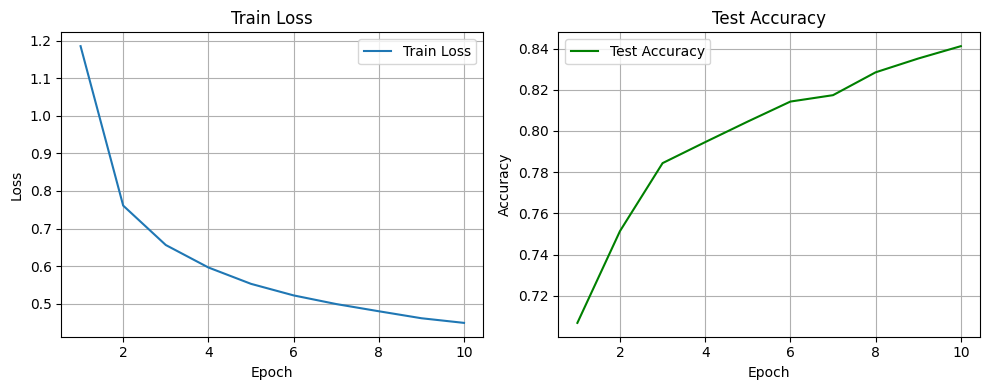

In [167]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_fashion, label='Train Loss')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_fashion, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Сохраняем веса общих слоев и первой головы

In [168]:
saved_state = {
    'conv': model.conv.state_dict(),
    'head1': model.head1.state_dict(),
    'head2': model.head2.state_dict()
}
torch.save(saved_state, "fashion_pretrained_head1.pth")

Загружаем модель с сохраненными весами (общая часть + первая голова)

In [169]:
model = MultiHeadCNN().to(device)
state_dict = torch.load("fashion_pretrained_head1.pth", map_location=device)
model.conv.load_state_dict(state_dict['conv'])
model.head1.load_state_dict(state_dict['head1'])
model.head2.load_state_dict(state_dict['head2'])

<All keys matched successfully>

## MNIST
Замораживаем веса для всех слоёв, кроме head2

In [170]:
for param in model.conv.parameters():
    param.requires_grad = False

In [171]:
for param in model.head1.parameters():
    param.requires_grad = True

Оптимизатор для head2

In [172]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [173]:
num_epochs = 10
train_losses_mnist = []
test_acc_mnist = []

In [174]:
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(mnist_train_loader, desc=f"Epoch {epoch}", leave=True):
        images, labels = images.to(device), labels.to(device)
        _, logits2 = model(images)
        loss = criterion(logits2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(mnist_train_loader)
    train_losses_mnist.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in mnist_test_loader:
            images, labels = images.to(device), labels.to(device)
            logits1, logits2 = model(images)
            preds = torch.argmax(logits2, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    test_acc_mnist.append(accuracy)

Epoch 10: 100%|██████████| 938/938 [00:37<00:00, 25.14it/s]


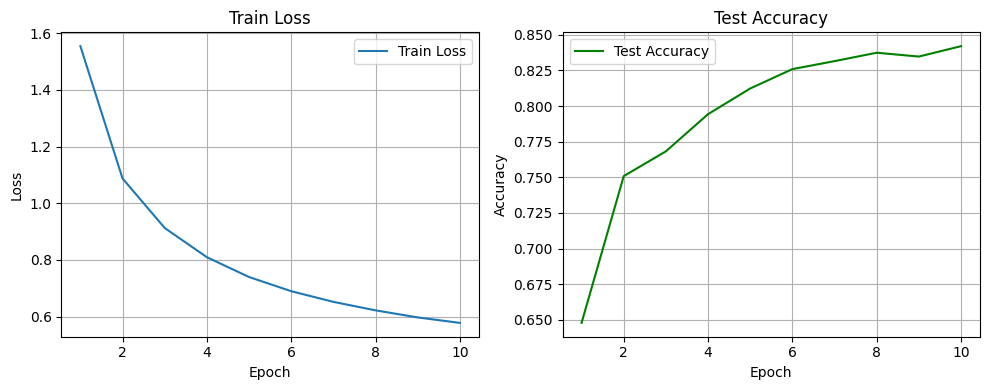

In [175]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_mnist, label='Train Loss')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_mnist, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## FashionMNIST и MNIST

In [176]:
for param in model.conv.parameters():
    param.requires_grad = True

In [177]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [178]:
num_epochs = 5
train_losses_joint = []
test_acc_fashion_joint = []
test_acc_mnist_joint = []

In [179]:
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    loop = tqdm(zip(fashion_train_loader, mnist_train_loader), total=min(len(fashion_train_loader), len(mnist_train_loader)), desc=f"Epoch {epoch}", leave=True)
    for (batch_fashion, batch_mnist) in loop:
        images_f, labels_f = batch_fashion
        images_m, labels_m = batch_mnist
        images_f, labels_f = images_f.to(device), labels_f.to(device)
        images_m, labels_m = images_m.to(device), labels_m.to(device)

        logits1_f, logits2_f = model(images_f)
        logits1_m, logits2_m = model(images_m)

        loss1 = criterion(logits1_f, labels_f)
        loss2 = criterion(logits2_m, labels_m)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    avg_loss = running_loss / len(fashion_train_loader)
    train_losses_joint.append(avg_loss)

    model.eval()
    correct_f = total_f = 0
    correct_m = total_m = 0
    with torch.no_grad():
        for images, labels in fashion_test_loader:
            images, labels = images.to(device), labels.to(device)
            logits1, logits2 = model(images)
            preds = torch.argmax(logits1, dim=1)
            correct_f += (preds == labels).sum().item()
            total_f += labels.size(0)
        for images, labels in mnist_test_loader:
            images, labels = images.to(device), labels.to(device)
            logits1, logits2 = model(images)
            preds = torch.argmax(logits2, dim=1)
            correct_m += (preds == labels).sum().item()
            total_m += labels.size(0)
    acc_f = correct_f / total_f
    acc_m = correct_m / total_m
    test_acc_fashion_joint.append(acc_f)
    test_acc_mnist_joint.append(acc_m)

Epoch 5: 100%|██████████| 938/938 [02:00<00:00,  7.76it/s, loss=0.624]


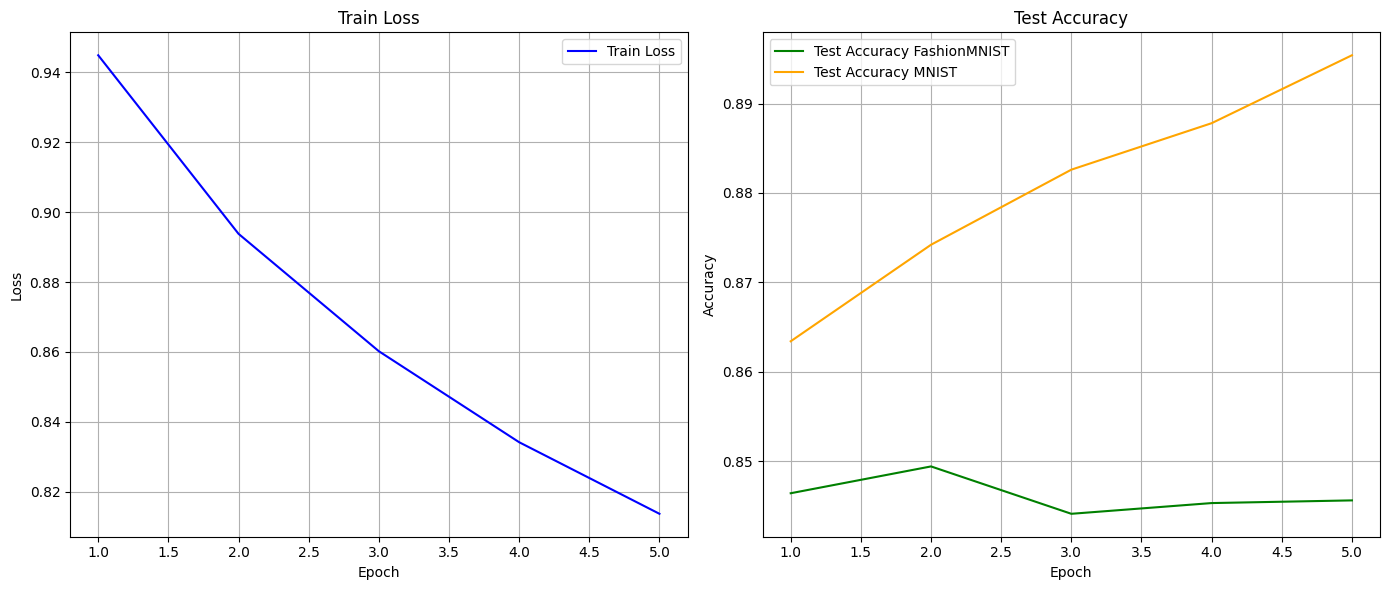

In [180]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_joint, label='Train Loss', color='blue')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_fashion_joint, label='Test Accuracy FashionMNIST', color='green')
plt.plot(range(1, num_epochs + 1), test_acc_mnist_joint, label='Test Accuracy MNIST', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Создаем модель и загружаем pre-trained веса FashionMNIST

In [181]:
model2 = MultiHeadCNN().to(device)
state_dict = torch.load("fashion_pretrained_head1.pth", map_location=device)
model2.conv.load_state_dict(state_dict['conv'])
model2.head1.load_state_dict(state_dict['head1'])

<All keys matched successfully>

In [182]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)

In [183]:
num_epochs = 15
train_losses_mnist2 = []
test_acc_mnist2 = []
test_acc_fashion2 = []

In [184]:
for epoch in range(1, num_epochs+1):
    model2.train()
    running_loss = 0.0
    for images, labels in tqdm(mnist_train_loader, desc=f"Epoch {epoch}", leave=True):
        images, labels = images.to(device), labels.to(device)
        _, logits2 = model2(images)
        loss = criterion(logits2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(mnist_train_loader)
    train_losses_mnist2.append(avg_loss)

    model2.eval()
    correct_m = total_m = 0
    correct_f = total_f = 0
    with torch.no_grad():
        for images, labels in mnist_test_loader:
            images, labels = images.to(device), labels.to(device)
            logits1, logits2 = model2(images)
            preds = torch.argmax(logits2, dim=1)
            correct_m += (preds == labels).sum().item()
            total_m += labels.size(0)
        for images, labels in fashion_test_loader:
            images, labels = images.to(device), labels.to(device)
            logits1, logits2 = model2(images)
            preds = torch.argmax(logits1, dim=1)
            correct_f += (preds == labels).sum().item()
            total_f += labels.size(0)
    acc_m = correct_m / total_m
    acc_f = correct_f / total_f
    test_acc_mnist2.append(acc_m)
    test_acc_fashion2.append(acc_f)

Epoch 15: 100%|██████████| 938/938 [00:51<00:00, 18.09it/s]


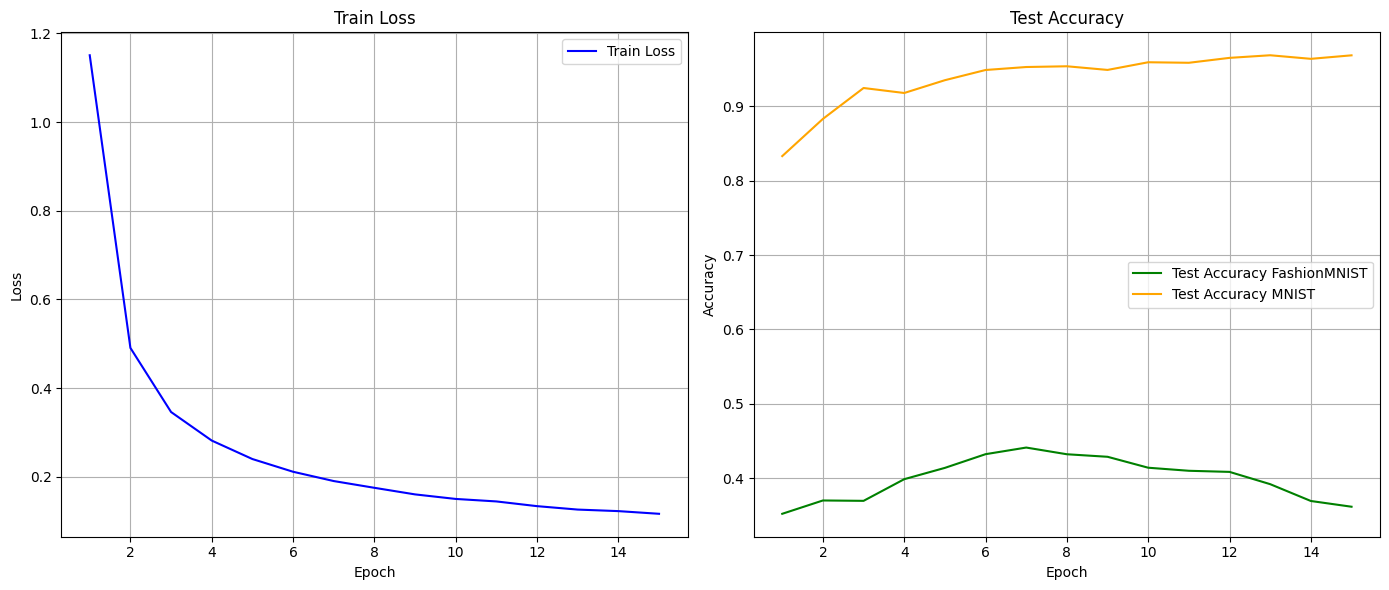

In [185]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_mnist2, label='Train Loss', color='blue')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_fashion2, label='Test Accuracy FashionMNIST', color='green')
plt.plot(range(1, num_epochs + 1), test_acc_mnist2, label='Test Accuracy MNIST', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Функция для вычисления косинусного расстояния между векторами

In [193]:
def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [202]:
def find_most_similar_image(model, test_loader, target_class_c, target_class_t):
    model.eval()
    logits_c = []
    logits_t = []
    images_c = []
    images_t = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data)
            for i in range(data.size(0)):
                if target[i] == target_class_c:
                    logits_c.append(logits[i])
                    images_c.append(data[i])
                elif target[i] == target_class_t:
                    logits_t.append(logits[i])
                    images_t.append(data[i])

    if not logits_c or not logits_t:
        return None, None

    logits_c = torch.stack(logits_c)
    logits_t = torch.stack(logits_t)

    most_similar_image = None
    min_distance = float('inf')
    closest_image_index = -1

    for i, logit_c in enumerate(logits_c):
        for j, logit_t in enumerate(logits_t):
            distance = cosine_similarity(logit_c, logit_t)
            if distance < min_distance:
                min_distance = distance
                most_similar_image = images_c[i]
                closest_image_index = i

    return most_similar_image, images_c[closest_image_index]